https://www.pymc.io/projects/examples/en/latest/time_series/MvGaussianRandomWalk_demo.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor

from scipy.linalg import cholesky

%matplotlib inline

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

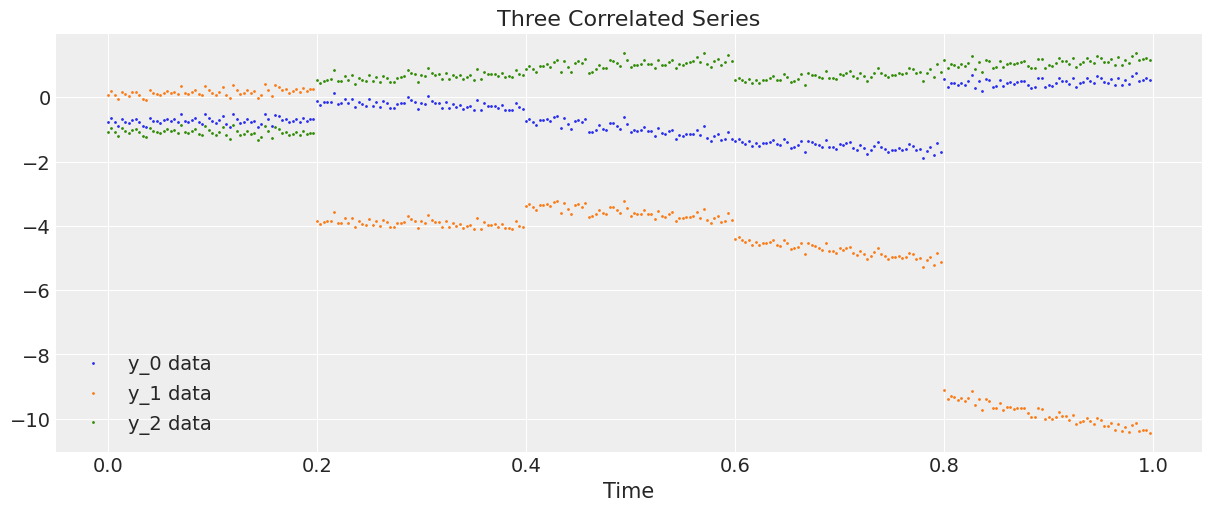

In [3]:
D = 3  # Dimension of random walks
N = 300  # Number of steps
sections = 5  # Number of sections
period = N / sections  # Number steps in each section

Sigma_alpha = rng.standard_normal((D, D))
Sigma_alpha = Sigma_alpha.T.dot(Sigma_alpha)  # Construct covariance matrix for alpha
L_alpha = cholesky(Sigma_alpha, lower=True)  # Obtain its Cholesky decomposition

Sigma_beta = rng.standard_normal((D, D))
Sigma_beta = Sigma_beta.T.dot(Sigma_beta)  # Construct covariance matrix for beta
L_beta = cholesky(Sigma_beta, lower=True)  # Obtain its Cholesky decomposition

# Gaussian random walks:
alpha = np.cumsum(L_alpha.dot(rng.standard_normal((D, sections))), axis=1).T
beta = np.cumsum(L_beta.dot(rng.standard_normal((D, sections))), axis=1).T
t = np.arange(N)[:, None] / N
alpha = np.repeat(alpha, period, axis=0)
beta = np.repeat(beta, period, axis=0)
# Correlated series
sigma = 0.1
y = alpha + beta * t + sigma * rng.standard_normal((N, 1))

# Plot the correlated series
plt.figure(figsize=(12, 5))
plt.plot(t, y, ".", markersize=2, label=("y_0 data", "y_1 data", "y_2 data"))
plt.title("Three Correlated Series")
plt.xlabel("Time")
plt.legend()
plt.show();

In [4]:
class Scaler:
    def __init__(self):
        mean_ = None
        std_ = None

    def transform(self, x):
        return (x - self.mean_) / self.std_

    def fit_transform(self, x):
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0)
        return self.transform(x)

    def inverse_transform(self, x):
        return x * self.std_ + self.mean_

In [5]:
def inference(t, y, sections, n_samples=100):
    N, D = y.shape

    # Standardize y and t
    y_scaler = Scaler()
    t_scaler = Scaler()
    y = y_scaler.fit_transform(y)
    t = t_scaler.fit_transform(t)
    # Create a section index
    t_section = np.repeat(np.arange(sections), N / sections)

    # Create PyTensor equivalent
    t_t = pytensor.shared(np.repeat(t, D, axis=1))
    y_t = pytensor.shared(y)
    t_section_t = pytensor.shared(t_section)

    coords = {"y_": ["y_0", "y_1", "y_2"], "steps": np.arange(N)}
    with pm.Model(coords=coords) as model:
        # Hyperpriors on Cholesky matrices
        chol_alpha, *_ = pm.LKJCholeskyCov(
            "chol_cov_alpha", n=D, eta=2, sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True
        )
        chol_beta, *_ = pm.LKJCholeskyCov(
            "chol_cov_beta", n=D, eta=2, sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True
        )

        # Priors on Gaussian random walks
        alpha = pm.MvGaussianRandomWalk(
            "alpha", mu=np.zeros(D), chol=chol_alpha, shape=(sections, D)
        )
        beta = pm.MvGaussianRandomWalk("beta", mu=np.zeros(D), chol=chol_beta, shape=(sections, D))

        # Deterministic construction of the correlated random walk
        alpha_r = alpha[t_section_t]
        beta_r = beta[t_section_t]
        regression = alpha_r + beta_r * t_t

        # Prior on noise ξ
        sigma = pm.HalfNormal("sigma", 1.0)

        # Likelihood
        likelihood = pm.Normal("y", mu=regression, sigma=sigma, observed=y_t, dims=("steps", "y_"))

        # MCMC sampling
        trace = pm.sample(n_samples, tune=1000, chains=4, target_accept=0.9)

        # Posterior predictive sampling
        pm.sample_posterior_predictive(trace, extend_inferencedata=True)

    return trace, y_scaler, t_scaler, t_section

In [6]:
trace, y_scaler, t_scaler, t_section = inference(t, y, sections)

/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:348: UserWarning: Initial distribution not specified, defaulting to `MvNormal.dist(0, I*100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:348: UserWarning: Initial distribution not specified, defaulting to `MvNormal.dist(0, I*100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


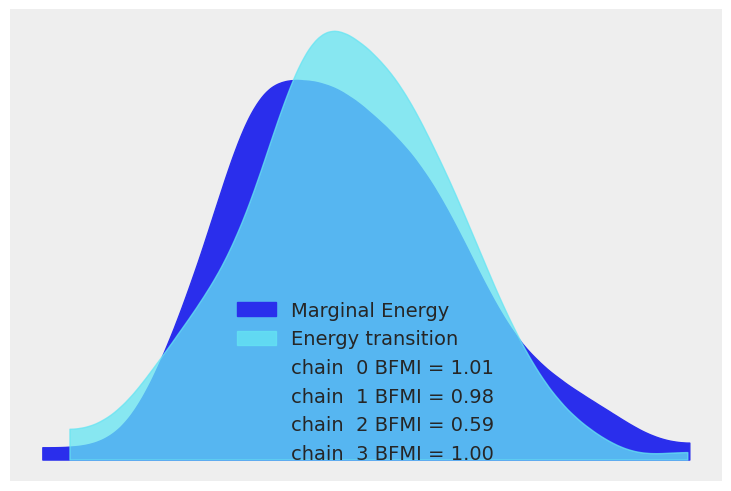

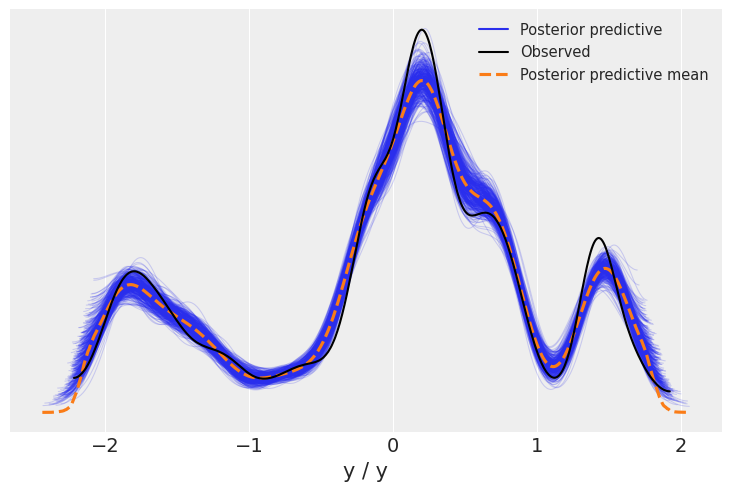

In [7]:
az.plot_energy(trace)
az.plot_ppc(trace);

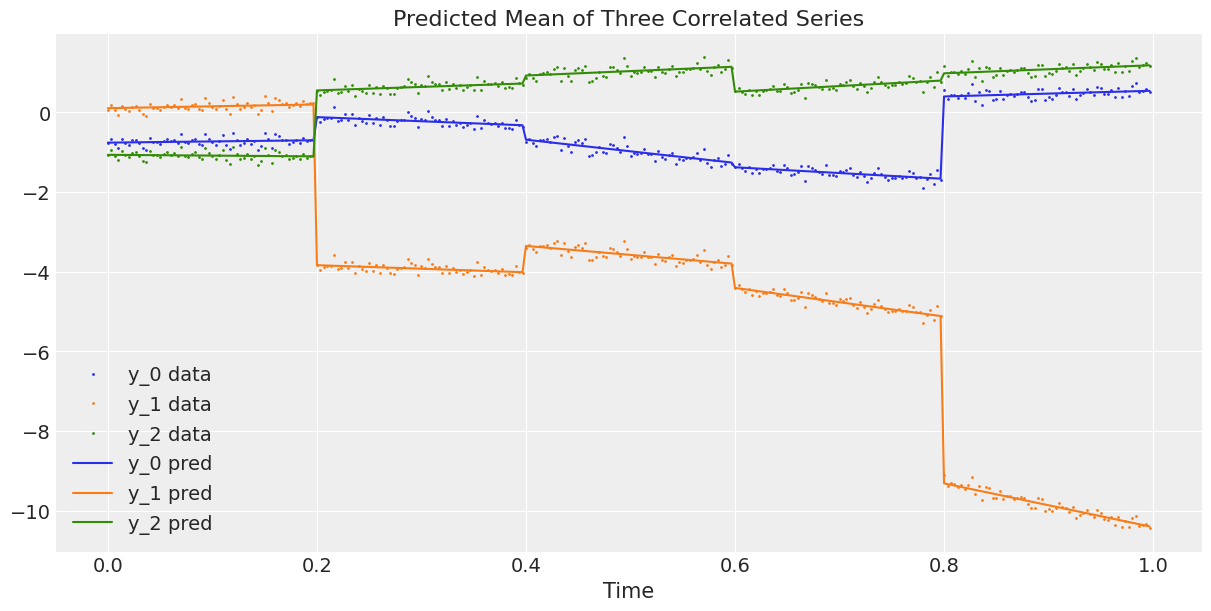

In [8]:
# Compute the predicted mean of the multivariate GRWs
alpha_mean = trace.posterior["alpha"].mean(dim=("chain", "draw"))
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw"))

# Compute the predicted mean of the correlated series
y_pred = y_scaler.inverse_transform(
    alpha_mean[t_section].values + beta_mean[t_section].values * t_scaler.transform(t)
)

# Plot the predicted mean
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(t, y, ".", markersize=2, label=("y_0 data", "y_1 data", "y_2 data"))
plt.gca().set_prop_cycle(None)
ax.plot(t, y_pred, label=("y_0 pred", "y_1 pred", "y_2 pred"))
ax.set_xlabel("Time")
ax.legend()
ax.set_title("Predicted Mean of Three Correlated Series");

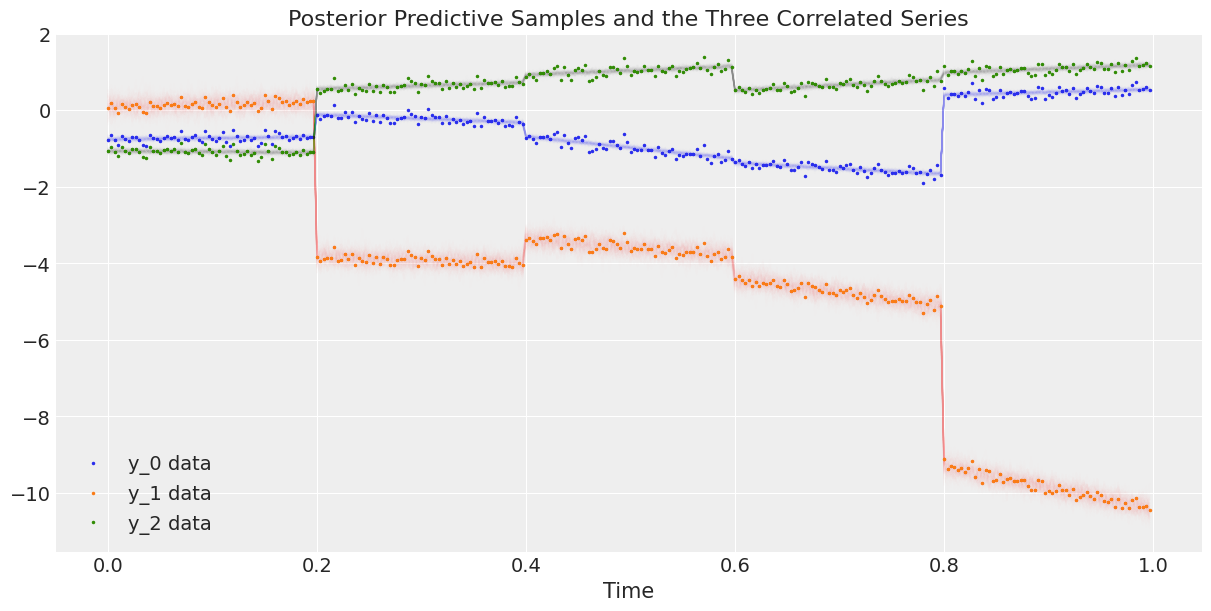

In [9]:
# Rescale the posterior predictive samples
ppc_y = y_scaler.inverse_transform(trace.posterior_predictive["y"].mean("chain"))

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot the data
ax.plot(t, y, ".", markersize=3, label=("y_0 data", "y_1 data", "y_2 data"))
# Plot the posterior predictive samples
ax.plot(t, ppc_y.sel(y_="y_0").T, color="C0", alpha=0.003)
ax.plot(t, ppc_y.sel(y_="y_1").T, color="C1", alpha=0.003)
ax.plot(t, ppc_y.sel(y_="y_2").T, color="C2", alpha=0.003)
ax.set_xlabel("Time")
ax.legend()
ax.set_title("Posterior Predictive Samples and the Three Correlated Series");

In [10]:
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00


In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Fri Dec 15 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

theano: not installed
xarray: 2023.7.0

arviz     : 0.15.1
matplotlib: 3.7.1
pymc      : 5.7.2
numpy     : 1.23.5
pytensor  : 2.14.2

Watermark: 2.4.3

